In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM


from scipy import stats


import random

import warnings  
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
def trainModel(train):
    """
    Training LSTM model
    input:
        train: training dataframe
    output:
        lstm_model: trainied lstm model
    """
    
    #scaling => translates each feature individually such that it is in the given range on the training set
    #to ensure the unit if our data is not a factor

    scaler = MinMaxScaler(feature_range=(0, 1))
    train_sc = scaler.fit_transform(train)

    #Reshaping the data to work for an LSTM network

    train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)


    for s in range(1,2):
        train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)

    X_train = train_sc_df.dropna().drop('Y', axis=1)
    y_train = train_sc_df.dropna().drop('X_1', axis=1)


    X_train = X_train.as_matrix()
    y_train = y_train.as_matrix()


    X_train_lmse = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
   

    print('Train shape: ', X_train_lmse.shape)
    

    lstm_model = Sequential()
    lstm_model.add(LSTM(7, input_shape=(1, X_train_lmse.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
    lstm_model.add(Dense(1))
    lstm_model.compile(loss='mean_squared_error', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
    history_lstm_model = lstm_model.fit(X_train_lmse, y_train, epochs=10, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

    return lstm_model

def testModel(lstm_model,test):
    """
    Testing the LSTM model
    input:
        test: testing dataframe
        lstm_model: trainied lstm model
    output:
        lstm_pred: inverse scaled dataframe of predicted values
        test_val: inverse scaled dataframe of original values
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    test_sc = scaler.fit_transform(test)
    X_test = test_sc[:-1]
    y_test = test_sc[1:]
    test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)
    for s in range(1,2):
        test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)


    X_test = test_sc_df.dropna().drop('Y', axis=1)
    y_test = test_sc_df.dropna().drop('X_1', axis=1)

    X_test = X_test.as_matrix()
    y_test = y_test.as_matrix()
    
    X_test_lmse = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    #print(X_test_lmse)
    y_pred_test_lstm = lstm_model.predict(X_test_lmse)
    
    #print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
    
    lstm_test_mse = lstm_model.evaluate(X_test_lmse, y_test, batch_size=1)
   
    print('LSTM: %f'%lstm_test_mse)
    
    #inversing the scaling
    lstm_pred = scaler.inverse_transform(y_pred_test_lstm)
    test_val = scaler.inverse_transform(y_test)
    
    return lstm_pred, test_val


def trainingData():
    """
    Reading Train Data 
    input:
        none
    output:
        data: training dataframe with index => DisplayTime value => GlucoseValues
    """
    
    data = pd.read_csv("~/Desktop/NCSA_genomics/Data/data_hall.txt", sep="\t")
    #data.head()
    
    #run only once
    #dropping columns we don't need
    
    #dropping rows we will use for testing
    #data.drop(index=['1636-69-001','1636-69-114','1636-69-028'])
    data = data[data.subjectId!='1636-69-001']
    data = data[data.subjectId!='1636-69-114']
    data = data[data.subjectId!='11636-69-028']
    
    data.drop(['subjectId', 'Internal Time'], axis=1, inplace=True)
    #df = data['GlucoseValue']
    #df.index = data['Display Time']
    
    #Converting the Display Time to 'datetime' so that it can be used as an index
    data['Display Time'] = data['Display Time'].apply(lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    data = data.set_index(['Display Time'], drop=True)
    #data.head()
    
    return data

def testingData():
    """
    Reading Test Data 
    input:
        none
    output:
        data: testing dataframe with index => DisplayTime value => GlucoseValues
    """
    data = pd.read_csv("~/Desktop/NCSA_genomics/Data/data_hall.txt", sep="\t")

    diabetic = data[data['subjectId'] == "1636-69-001"]
    prediabetic = data[data['subjectId'] == "1636-69-114"]
    non_diabetic = data[data['subjectId'] == "1636-69-028"]
    
    diabetic.drop(['subjectId', 'Internal Time'], axis=1, inplace=True)
    prediabetic.drop(['subjectId', 'Internal Time'], axis=1, inplace=True)
    non_diabetic.drop(['subjectId', 'Internal Time'], axis=1, inplace=True)
    
    
    diabetic['Display Time'] = diabetic['Display Time'].apply(lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    diabetic = diabetic.set_index(['Display Time'], drop=True)

    prediabetic['Display Time'] = prediabetic['Display Time'].apply(lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    prediabetic = prediabetic.set_index(['Display Time'], drop=True)

    non_diabetic['Display Time'] = non_diabetic['Display Time'].apply(lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    non_diabetic = non_diabetic.set_index(['Display Time'], drop=True)

    return diabetic, prediabetic, non_diabetic
    
    

def plot(lstm_pred, test_val):
    #plotting true values and lstm predicted values
    #these are original values
    
    plt.figure(figsize=(20, 8))
    
    
    plt.plot(lstm_pred, label='LSTM', color='red', linewidth=2)
    plt.plot(test_val, label='True', color='#2280f2', linewidth=2.5)
    
    plt.title("LSTM's Prediction")
    
    plt.xlabel('Observation')
    plt.ylabel('Glucose Values')
    plt.legend()
    plt.show();
    
def getMetrics(lstm_pred, test_val):
    #IOA
    ioa_val = index_agreement(lstm_pred,test_val)
    print("Index of Agreement is: " + str(ioa_val))

    #MAE
    mae_val = mae(lstm_pred,test_val)
    print("Mean Absolute Error is: " + str(mae_val))

    #RMSE
    rmse_val = rmse(lstm_pred,test_val)
    print("Root Mean Squared Error is: " + str(rmse_val))
    
    #MAD
    mad_val = mad(lstm_pred)
    print("Mean Absolute Difference is:: " + str(mad_val))
    
    #FB
    fb_val = fracBias(lstm_pred,test_val)
    print("Fractional Bias is: " + str(rmse_val))
    
    #MAPE
    mape_val = mape(lstm_pred,test_val)
    print("Mean Absolute Percentage Error is: " + str(mape_val))
    
    
def index_agreement(s,o):
    """
    index of agreement
    input:
        s: prediceted
        o: original
    output:
        ia: index of agreement
    """
    
    ia = 1 -(np.sum((o-s)**2))/(np.sum((np.abs(s-np.mean(o))+np.abs(o-np.mean(o)))**2))
    
    return ia

def rmse(s,o):
    """
    Root Mean Squared Error
    input:
        s: prediceted
        o: original
    output:
        rmses: root mean squared error
    """
    return np.sqrt(np.mean((s-o)**2))

def mae(s,o):
    """
    Mean Absolute Error
    input:
        s: prediceted
        o: original
    output:
        maes: mean absolute error
    """
    return np.mean(abs(s-o))

def mad(s):
    """
    Mean Absolute Difference
    input:
        s: prediceted
    output:
        mad: mean absolute error
    """
  
    return stats.median_absolute_deviation(s)
    


def mape(y_pred,y_true):
    """
    Mean Absolute Percentage error
    input:
        y_pred: prediceted
        y_true: original
    output:
        mape: Mean Absolute Percentage error
    """

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def fracBias(s,o):
    """
    Fractional Bias
    input:
        s: prediceted
        o: original
    output:
        fracBias: Fractional Bias
    """
    
    return np.mean(np.abs((o - s) / ((o + s)/2)))



def createGap(data):
    """
    Creating Gap indexes
    input:
        data: dataframe with index => DisplayTime value => GlucoseValues
    output:
        start: seed
        end: seed+gap (gap=300)
    """
    
    seed = random.randint(500,len(data)-500)
    
    return seed,seed+500


def faultyData(df,start,end):
    """
    Creating a Gap
    input:
        start: seed
        end: seed+gap (gap=300)
    output:
        df: dataframe with index => DisplayTime value => GlucoseValues and a gap from start to end (inputs)
    """
    
    #df = readData()
    for i in range(start,end):
        df['GlucoseValue'][i]=0
    
    return df

def summaryPlot(p1,t1,p2,t2,p3,t3):
    
    plt.figure(figsize=(20, 20))

    plt.subplot(3, 1, 1)
    plt.plot(p1, label='LSTM', color='red', linewidth=2)
    plt.plot(t1, label='True', color='#2280f2', linewidth=2.5)
    plt.xlabel('Observation')
    plt.ylabel('Glucose Values')
    plt.title("Diabetic - 1")
    plt.legend()
    
    
    plt.subplot(3, 1, 2)
    plt.plot(p2, label='LSTM', color='red', linewidth=2)
    plt.plot(t2, label='True', color='#2280f2', linewidth=2.5)
    plt.xlabel('Observation')
    plt.ylabel('Glucose Values')
    plt.title("Prediabetic")
    plt.legend()
    
    plt.subplot(3, 1, 3)
    plt.plot(p3, label='LSTM', color='red', linewidth=2)
    plt.plot(t3, label='True', color='#2280f2', linewidth=2.5)
    plt.xlabel('Observation')
    plt.ylabel('Glucose Values')
    plt.title("Nondiabetic")
    plt.legend()
    
    
    plt.show();
    

In [3]:
#removed rows from training data
train_set = trainingData()
print(train_set)


                     GlucoseValue
Display Time                     
2015-11-24 00:37:20           123
2015-11-24 00:42:20           122
2015-11-24 00:47:20           119
2015-11-24 00:52:20           114
2015-11-24 00:57:20           111
...                           ...
2017-07-11 20:21:32            70
2017-07-11 20:26:32            64
2017-07-11 20:31:32            61
2017-07-11 20:36:32            62
2017-07-11 20:41:32            66

[101784 rows x 1 columns]


In [4]:
#Training the model on all the data except for the ones ones for testing
#That is, one row observed as diabetic, prediabetic and non-diabetic each has been explicitly removed
#The model has thus, never sen the test data

In [5]:
lstmModel = trainModel(train_set)

Train shape:  (101783, 1, 1)
Epoch 1/10
101783/101783 [==============================] - 235s 2ms/step - loss: 4.5696e-04
Epoch 2/10
101783/101783 [==============================] - 188s 2ms/step - loss: 3.4804e-04
Epoch 3/10
101783/101783 [==============================] - 199s 2ms/step - loss: 3.4643e-04
Epoch 4/10
101783/101783 [==============================] - 218s 2ms/step - loss: 3.4486e-04
Epoch 5/10
101783/101783 [==============================] - 207s 2ms/step - loss: 3.4265e-04
Epoch 6/10
101783/101783 [==============================] - 207s 2ms/step - loss: 3.3854e-04
Epoch 7/10
101783/101783 [==============================] - 205s 2ms/step - loss: 3.3405e-04
Epoch 8/10
101783/101783 [==============================] - 209s 2ms/step - loss: 3.3350e-04
Epoch 9/10
101783/101783 [==============================] - 214s 2ms/step - loss: 3.3315e-04
Epoch 10/10
101783/101783 [==============================] - 209s 2ms/step - loss: 3.3283e-04


In [6]:
#extracting data for testing the data and creating a gap of missing values
#predicting the missing values 
#plotting the graph for the same

In [7]:
diabetic , prediabetic, non_diabetic = testingData()
diabetic2 , prediabetic2, non_diabetic2 = testingData()
start, end = createGap(diabetic)
gap_tester_diabetic = diabetic.iloc[start:end+2]
diabetic2 = faultyData(diabetic2,start,end+1)
#print(diabetic.iloc[start:end])
#print(gap_tester_diabetic)
#start,end

In [8]:
predicted1, true1 = testModel(lstmModel,gap_tester_diabetic)

501/501 [==============================] - 0s 879us/step
LSTM: 0.005202


In [9]:
print(end,start)
print(len(predicted1))

1650 1150
501


In [10]:

for i in range(0,501):
    diabetic2['GlucoseValue'][start+i] = predicted1[i][0]
    

In [11]:
# diabetic2['GlucoseValue'][end-1] = (diabetic2['GlucoseValue'][end-2]+diabetic2['GlucoseValue'][end])/2

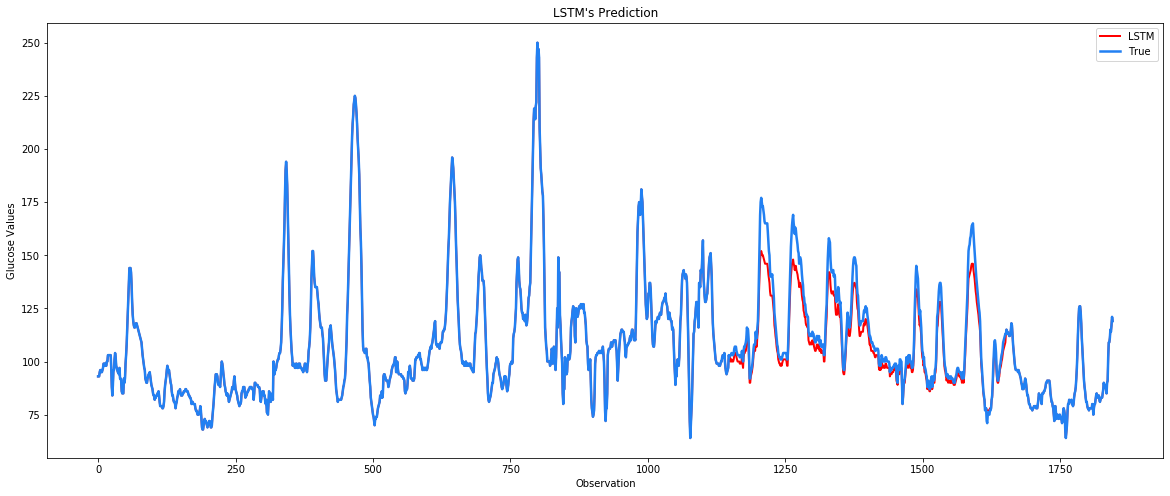

In [12]:
plot(diabetic2['GlucoseValue'].tolist(),diabetic['GlucoseValue'].tolist())

In [13]:
getMetrics(predicted1,true1)

Index of Agreement is: 0.964114147182456
Mean Absolute Error is: 5.460441391387146
Root Mean Squared Error is: 7.645246394327304
Mean Absolute Difference is:: [15.784828]
Fractional Bias is: 7.645246394327304
Mean Absolute Percentage Error is: 4.28987047990712


In [14]:
diabetic , prediabetic, non_diabetic = testingData()
diabetic2 , prediabetic2, non_diabetic2 = testingData()
start, end = createGap(prediabetic)
gap_tester_prediabetic = prediabetic.iloc[start:end+2]
prediabetic2 = faultyData(prediabetic2,start,end+1)
#print(diabetic.iloc[start:end])
#print(gap_tester_diabetic)
#start,end

In [15]:
predicted2, true2 = testModel(lstmModel,gap_tester_prediabetic)

501/501 [==============================] - 0s 731us/step
LSTM: 0.011207


In [16]:
for i in range(0,501):
    prediabetic2['GlucoseValue'][start+i] = predicted2[i][0]

In [17]:
#prediabetic2['GlucoseValue'][end-1] = (prediabetic2['GlucoseValue'][end-2]+prediabetic2['GlucoseValue'][end])/2

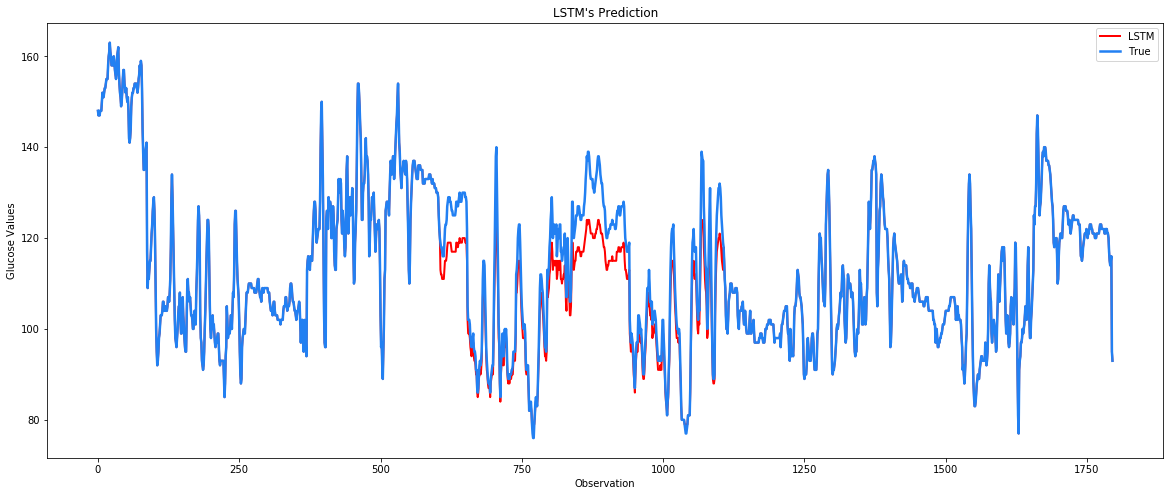

In [18]:
plot(prediabetic2['GlucoseValue'].tolist(),prediabetic['GlucoseValue'].tolist())

In [19]:
getMetrics(predicted2,true2)

Index of Agreement is: 0.9468547371387303
Mean Absolute Error is: 5.412432383158488
Root Mean Squared Error is: 6.775245704082388
Mean Absolute Difference is:: [15.468982]
Fractional Bias is: 6.775245704082388
Mean Absolute Percentage Error is: 4.609329846459409


In [20]:
diabetic , prediabetic, non_diabetic = testingData()
diabetic2 , prediabetic2, non_diabetic2 = testingData()
start, end = createGap(non_diabetic)
gap_tester_non_diabetic = non_diabetic.iloc[start:end+2]
non_diabetic2 = faultyData(non_diabetic2,start,end+1)
#print(diabetic.iloc[start:end])
#print(gap_tester_diabetic)
#start,end

In [21]:
predicted3, true3 = testModel(lstmModel,gap_tester_non_diabetic)

501/501 [==============================] - 0s 728us/step
LSTM: 0.002855


In [22]:
for i in range(0,501):
    non_diabetic2['GlucoseValue'][start+i] = predicted3[i][0]

In [23]:
# non_diabetic2['GlucoseValue'][end-1] = (non_diabetic2['GlucoseValue'][end-2]+non_diabetic2['GlucoseValue'][end])/2

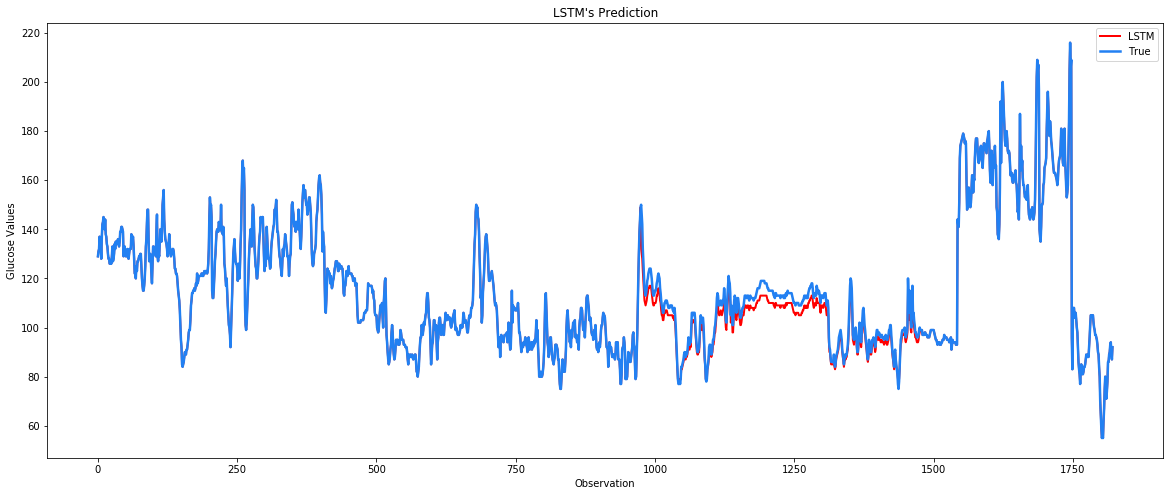

In [24]:
plot(non_diabetic2['GlucoseValue'].tolist(),non_diabetic['GlucoseValue'].tolist())

In [25]:
getMetrics(predicted3,true3)

Index of Agreement is: 0.9642328540161893
Mean Absolute Error is: 3.334424793601274
Root Mean Squared Error is: 4.0071008465758835
Mean Absolute Difference is:: [9.796503]
Fractional Bias is: 4.0071008465758835
Mean Absolute Percentage Error is: 3.122343351526656


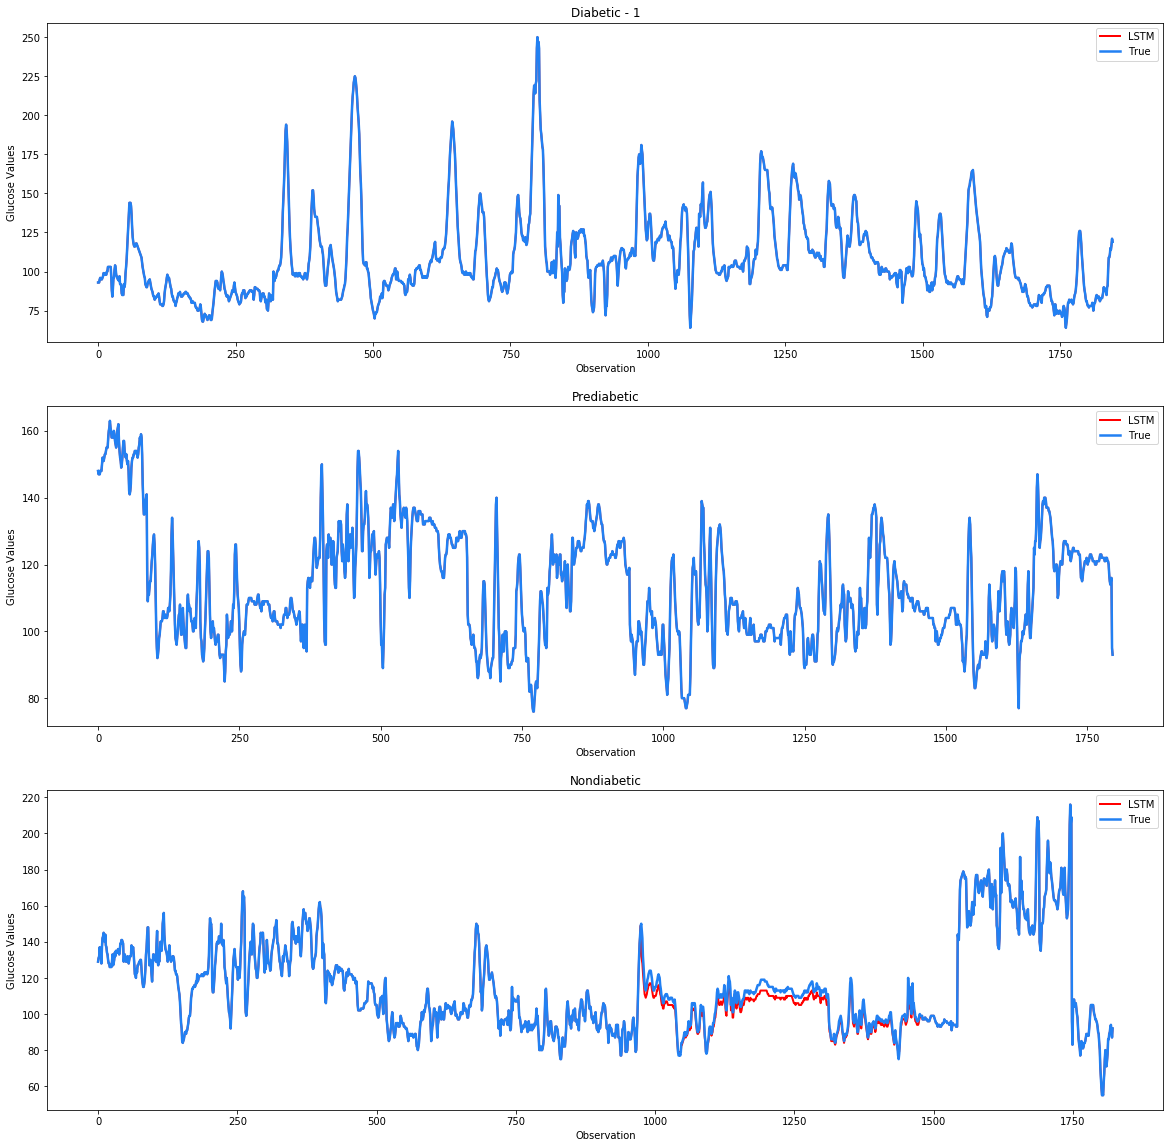

In [31]:
summaryPlot(diabetic2['GlucoseValue'].tolist(),diabetic['GlucoseValue'].tolist(),prediabetic2['GlucoseValue'].tolist(),prediabetic['GlucoseValue'].tolist(),non_diabetic2['GlucoseValue'].tolist(),non_diabetic['GlucoseValue'].tolist())